# Test EmissionSimulator
This notebook demonstrates and tests the `EmissionSimulator` class and its `simulate` method using mock managers and configurations.

In [17]:
# Setup paths and imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
base_path = os.path.abspath("../..")
sys.path.append(base_path)
from sbi_delta.config import BaseConfig, ExcitationConfig, FilterConfig, PriorConfig
from sbi_delta.spectra_manager import SpectraManager
from sbi_delta.excitation_manager import ExcitationManager
from sbi_delta.filter_bank import FilterBank
from sbi_delta.prior_manager import PriorManager
from sbi_delta.simulator.emission_simulator import EmissionSimulator


In [33]:
# Configuration and manager setup
spectra_folder = os.path.join(base_path, "data/spectra_npz")
dye_names = ["JF479", "JF552", "JFX673"]
base_cfg = BaseConfig(
    min_wavelength=400,
    max_wavelength=750,
    wavelength_step=1,
    spectra_folder=spectra_folder,
    dye_names=dye_names,
    bg_dye="AF_v1",
    photon_budget=10000
)
exc_cfg = ExcitationConfig(excitation_mode="min_crosstalk")
filter_cfgs = [
    FilterConfig(start=520, stop=550, sharpness=1),
    FilterConfig(start=550, stop=580, sharpness=2),
    FilterConfig(start=580, stop=610, sharpness=2),
    FilterConfig(start=610, stop=640, sharpness=2),
    FilterConfig(start=640, stop=700, sharpness=2)
]
prior_cfg = PriorConfig(dirichlet_concentration=5.0, include_background_ratio=True, background_ratio_bounds=(0.08, 0.12))

spectra_mgr = SpectraManager(base_cfg)
spectra_mgr.load()
excitation_mgr = ExcitationManager(base_cfg, exc_cfg, spectra_mgr)
filter_bank = FilterBank(base_cfg, filter_cfgs)
prior_mgr = PriorManager(prior_cfg, base_cfg)


INFO:sbi_delta.spectra_manager:Initialized SpectraManager(folder=/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz, dyes=['JF479', 'JF552', 'JFX673'], bg_dye=AF_v1)
INFO:sbi_delta.spectra_manager:Starting load() of spectra
INFO:sbi_delta.spectra_manager:Found 22 .npz files in '/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF479' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF479.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF479'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF552' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF552.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF552'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JFX673' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JFX673.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JFX673'
INFO:sbi_delta.spectra_manager:L

In [34]:
sim = EmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr
)
# Optionally attach background_manager if you have one, e.g.:
# sim.background_manager = ...

In [35]:
# Define test concentrations
# Sample from prior
joint_prior = prior_mgr.get_joint_prior()
concentrations = joint_prior.sample((1,)).numpy()

print("Sampled concentrations from prior:", concentrations)

Sampled concentrations from prior: [[0.18978111 0.3330448  0.47717407 0.1118236 ]]


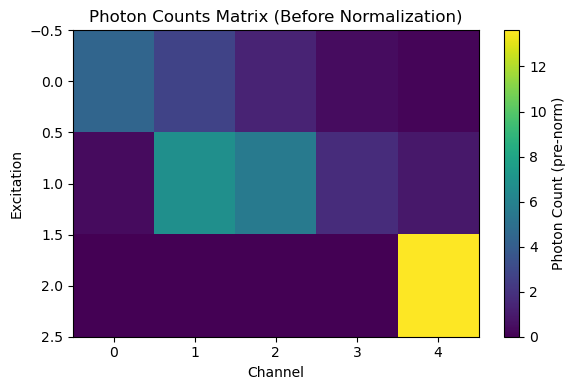

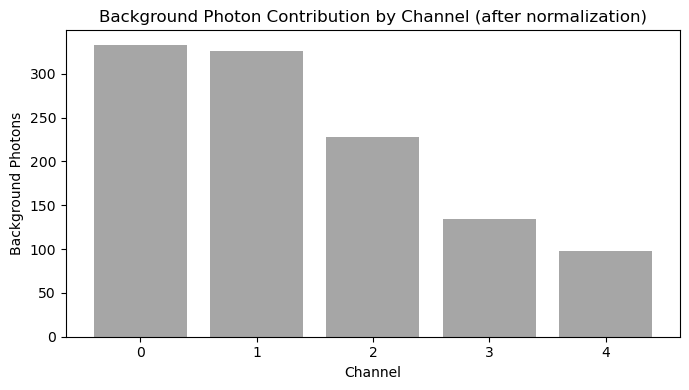

--- Normalization math ---
total_signal = np.sum(signal_matrix_pre_norm) = 38.128
photon_budget = 10000.000
signal_matrix_norm = signal_matrix_pre_norm / total_signal * photon_budget
--- Matrix after normalization (before BG) ---
[[1.16170183e+03 7.22550260e+02 3.52694035e+02 1.14510387e+02
  4.37891487e+01]
 [1.01797804e+02 1.78085029e+03 1.45878236e+03 4.57992142e+02
  2.24934017e+02]
 [1.43416511e-31 1.29101967e-09 4.20407501e-03 1.22810020e+01
  3.56811253e+03]]


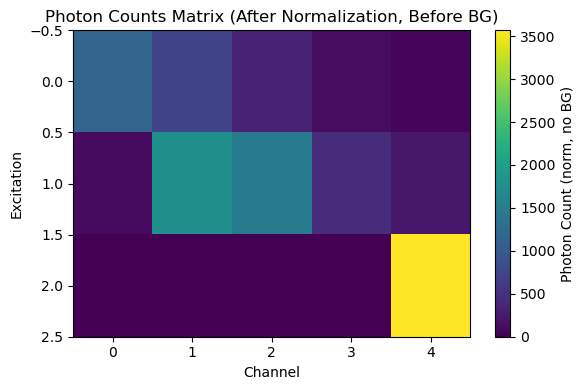

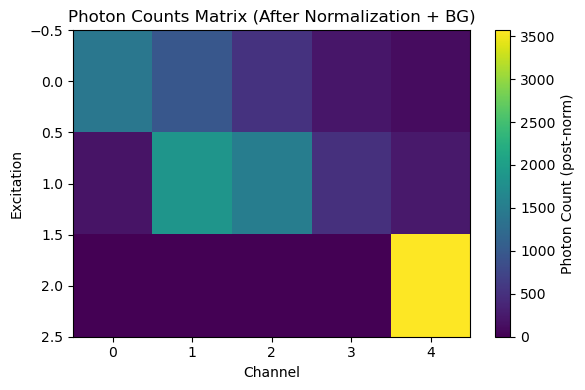

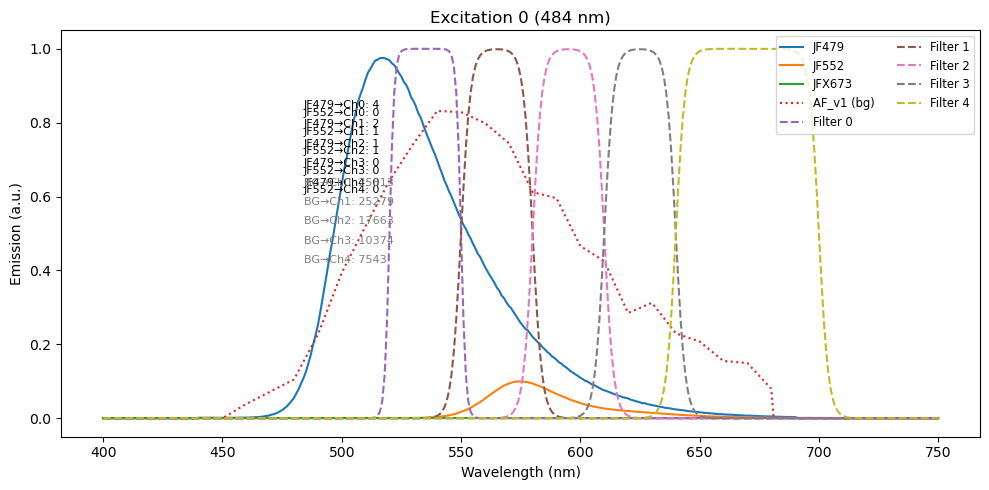

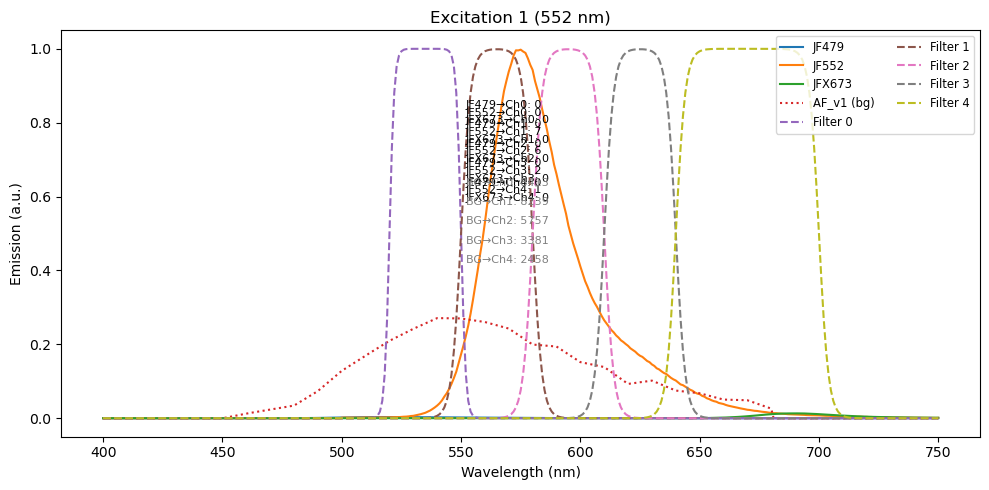

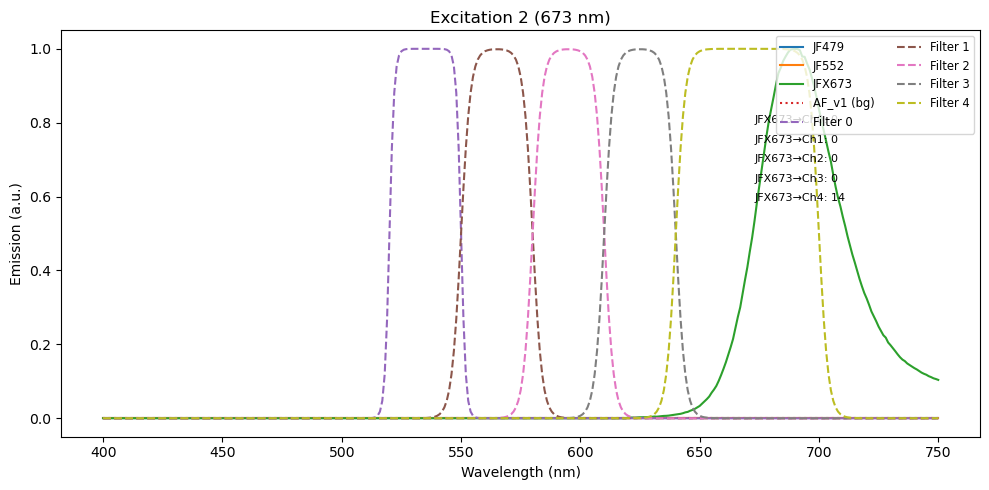

Photon counts matrix (excitation x channel):
[[1.41287954e+03 9.68527236e+02 5.24566130e+02 2.15451896e+02
  1.17184088e+02]
 [1.83662794e+02 1.86102024e+03 1.51479970e+03 4.90891461e+02
  2.48855232e+02]
 [1.43416511e-31 1.29101967e-09 4.20407501e-03 1.22810020e+01
  3.56811253e+03]]
Noiseless photon counts (shape: batch, n_exc, n_ch): (1, 3, 5)
[[[1.41287954e+03 9.68527236e+02 5.24566130e+02 2.15451896e+02
   1.17184088e+02]
  [1.83662794e+02 1.86102024e+03 1.51479970e+03 4.90891461e+02
   2.48855232e+02]
  [1.43416511e-31 1.29101967e-09 4.20407501e-03 1.22810020e+01
   3.56811253e+03]]]


In [36]:
# Run simulation without noise
counts_noiseless = []
for conc in concentrations:
    counts = sim.simulate(concentrations=conc, add_noise=False, debug=True)
    counts_noiseless.append(counts)
counts_noiseless = np.array(counts_noiseless)
print("Noiseless photon counts (shape: batch, n_exc, n_ch):", counts_noiseless.shape)
print(counts_noiseless)

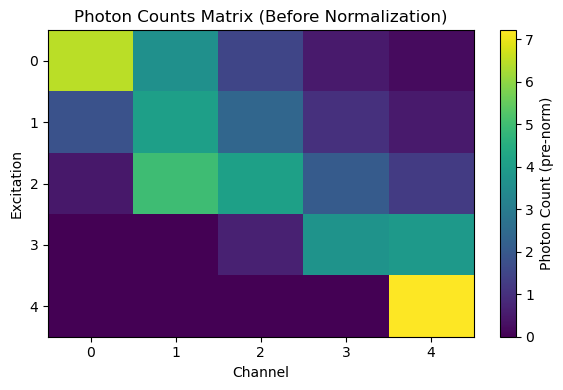

--- Normalization math ---
total_signal = np.sum(signal_matrix_pre_norm) = 50.498
photon_budget = 10000.000
signal_matrix_norm = signal_matrix_pre_norm / total_signal * photon_budget
--- Matrix after normalization (before BG) ---
[[1.27837001e+03 7.14576180e+02 2.96777499e+02 1.05149934e+02
  4.31926738e+01]
 [3.62046278e+02 8.09117973e+02 4.70634886e+02 1.99495698e+02
  1.03731008e+02]
 [8.99731906e+01 9.83953652e+02 8.13689203e+02 4.09108544e+02
  2.47034918e+02]
 [8.26319926e-12 3.02376401e+00 1.32199304e+02 7.32640052e+02
  7.71560741e+02]
 [5.74293084e-32 5.16972320e-10 1.68346809e-03 4.91777023e+00
  1.42880504e+03]]


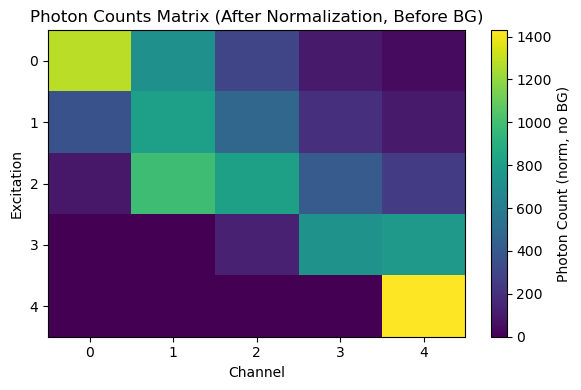

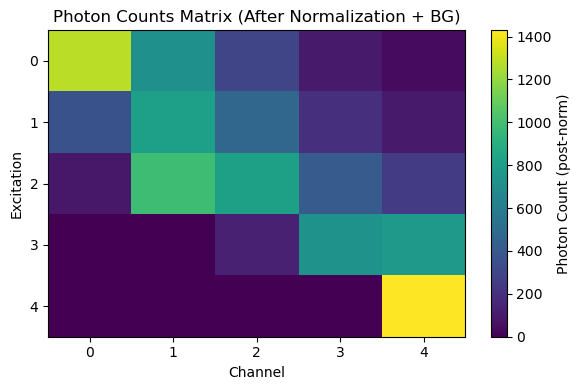

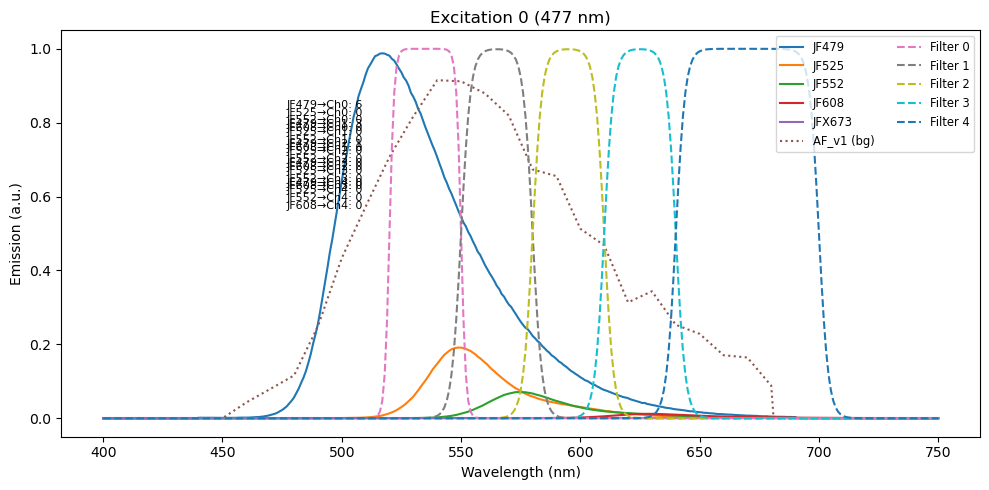

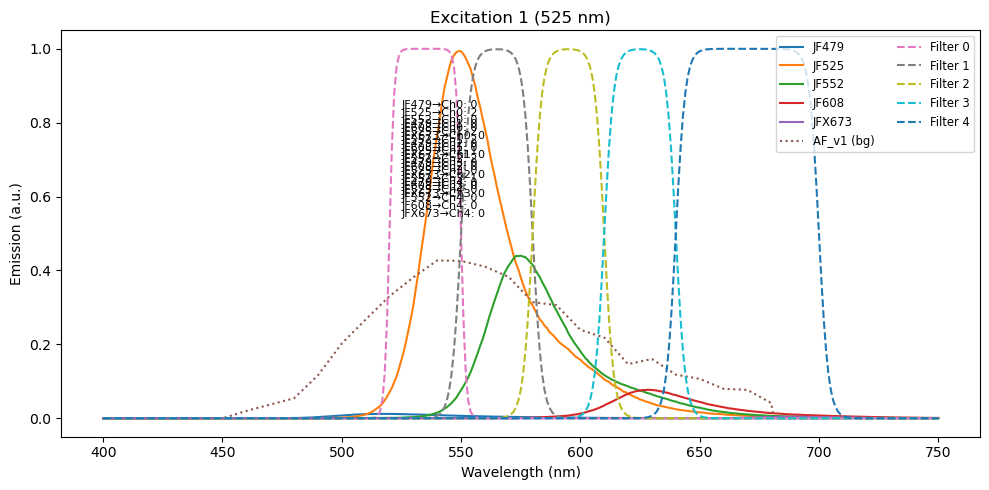

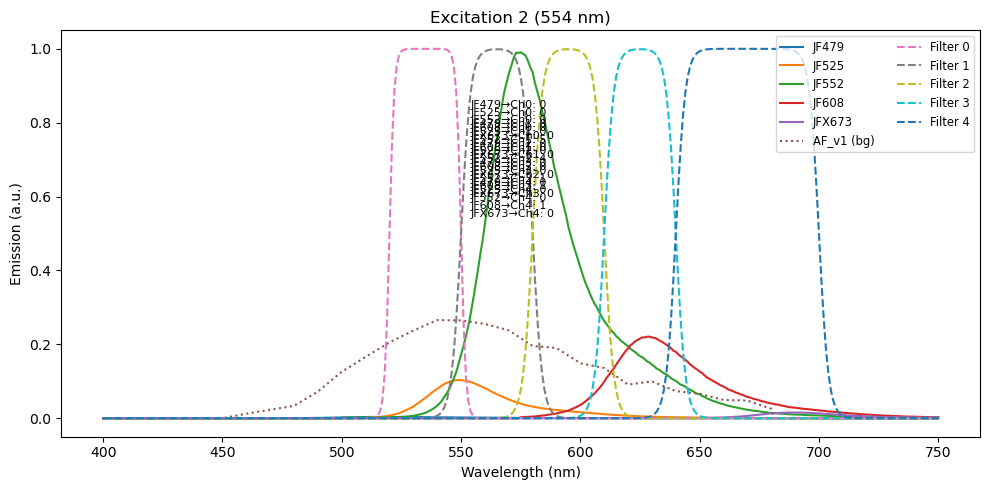

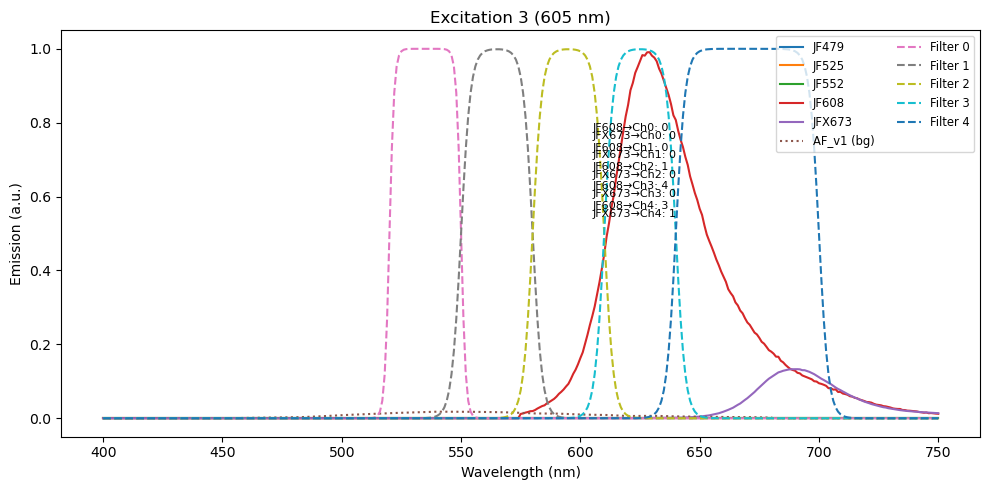

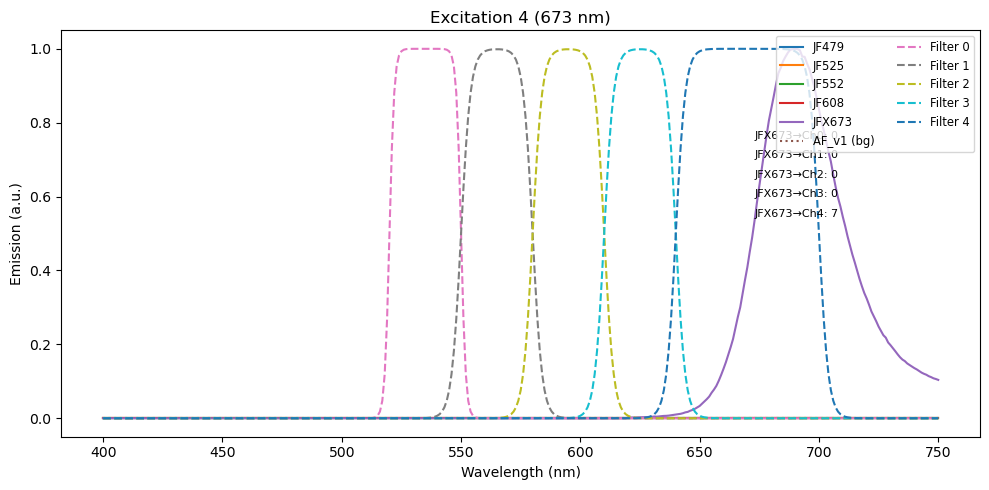

Photon counts matrix (excitation x channel):
[[1229  727  332  112   38]
 [ 336  815  454  179   95]
 [  87  964  887  438  227]
 [   0    2  141  771  703]
 [   0    0    0    8 1463]]
Noiseless photon counts (shape: batch, n_exc, n_ch): (1, 5, 5)
[[[1229  727  332  112   38]
  [ 336  815  454  179   95]
  [  87  964  887  438  227]
  [   0    2  141  771  703]
  [   0    0    0    8 1463]]]


In [26]:
# Run simulation without noise
counts_noiseless = []
for conc in concentrations:
    counts = sim.simulate(concentrations=conc, add_noise=True, debug=True)
    counts_noiseless.append(counts)
counts_noiseless = np.array(counts_noiseless)
print("Noiseless photon counts (shape: batch, n_exc, n_ch):", counts_noiseless.shape)
print(counts_noiseless)

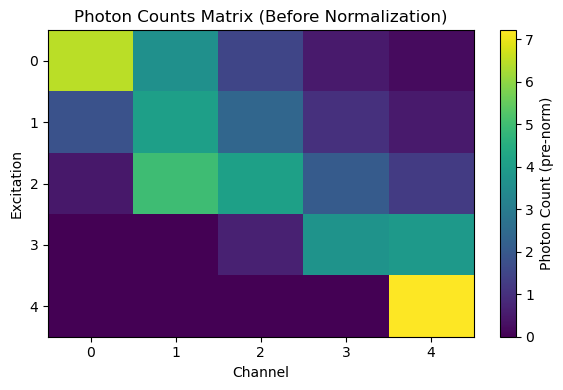

--- Normalization math ---
total_signal = np.sum(signal_matrix_pre_norm) = 50.498
photon_budget = 10000.000
signal_matrix_norm = signal_matrix_pre_norm / total_signal * photon_budget
--- Matrix after normalization (before BG) ---
[[1.27837001e+03 7.14576180e+02 2.96777499e+02 1.05149934e+02
  4.31926738e+01]
 [3.62046278e+02 8.09117973e+02 4.70634886e+02 1.99495698e+02
  1.03731008e+02]
 [8.99731906e+01 9.83953652e+02 8.13689203e+02 4.09108544e+02
  2.47034918e+02]
 [8.26319926e-12 3.02376401e+00 1.32199304e+02 7.32640052e+02
  7.71560741e+02]
 [5.74293084e-32 5.16972320e-10 1.68346809e-03 4.91777023e+00
  1.42880504e+03]]


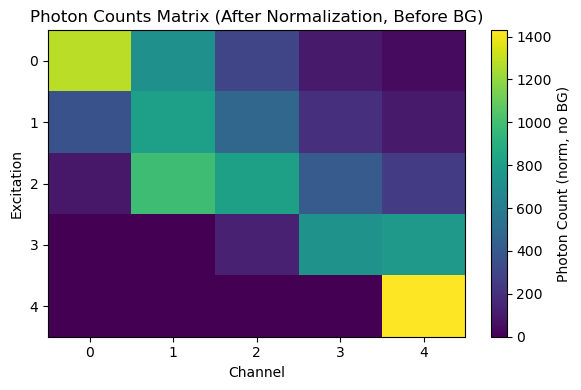

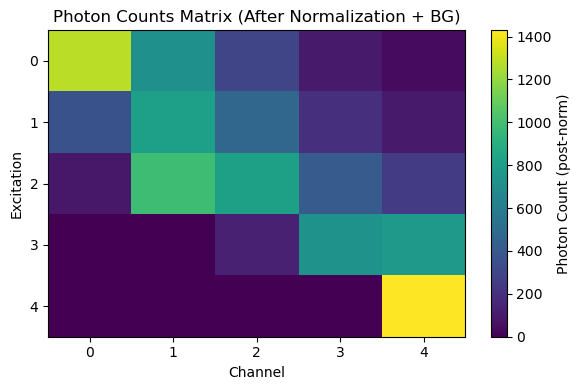

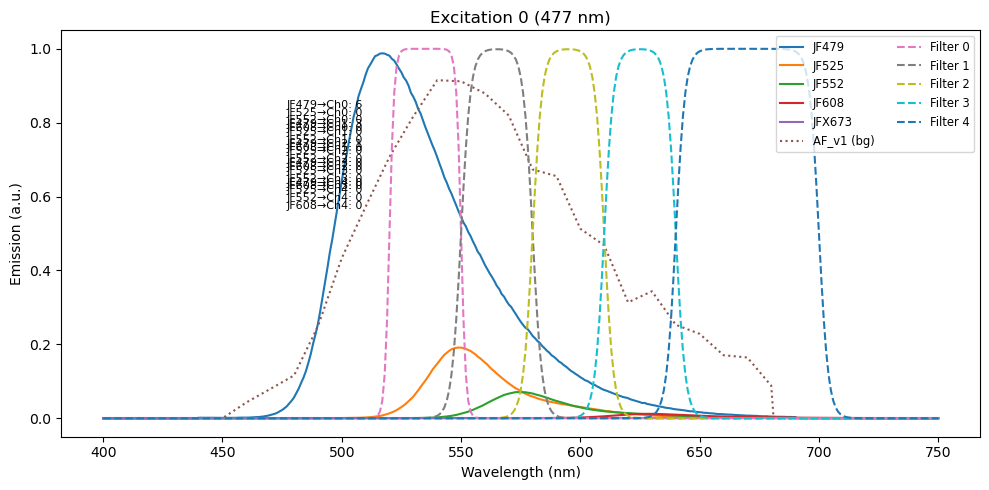

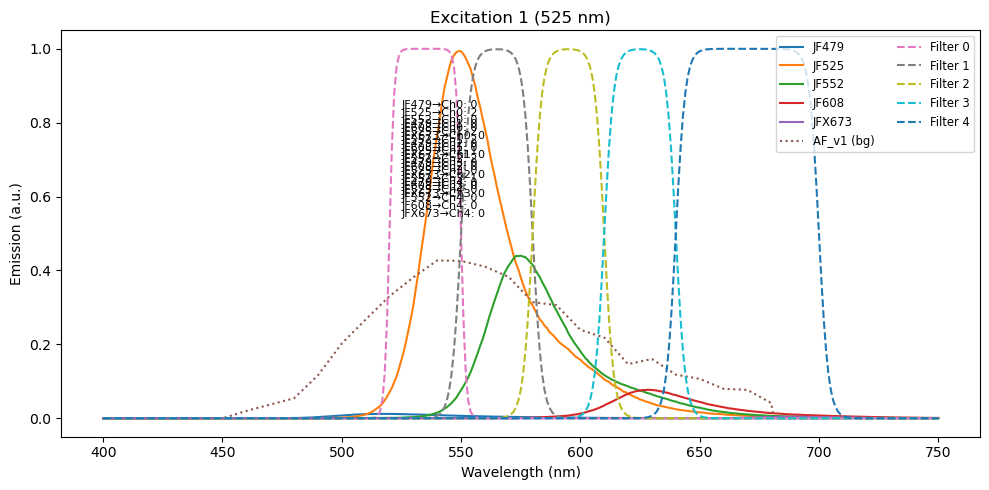

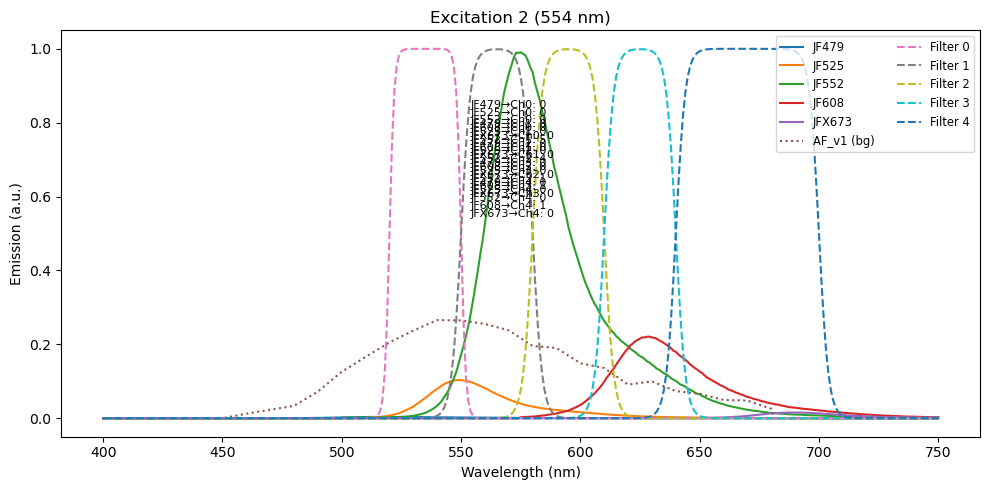

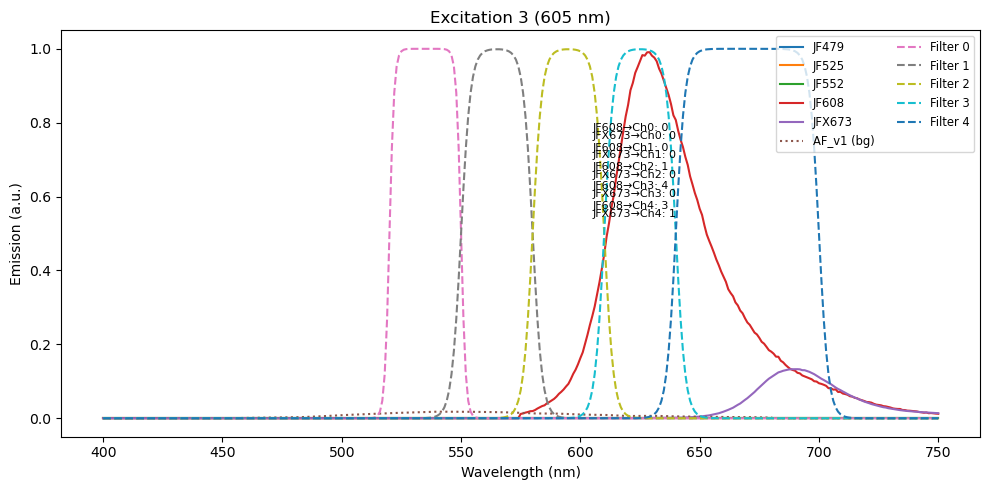

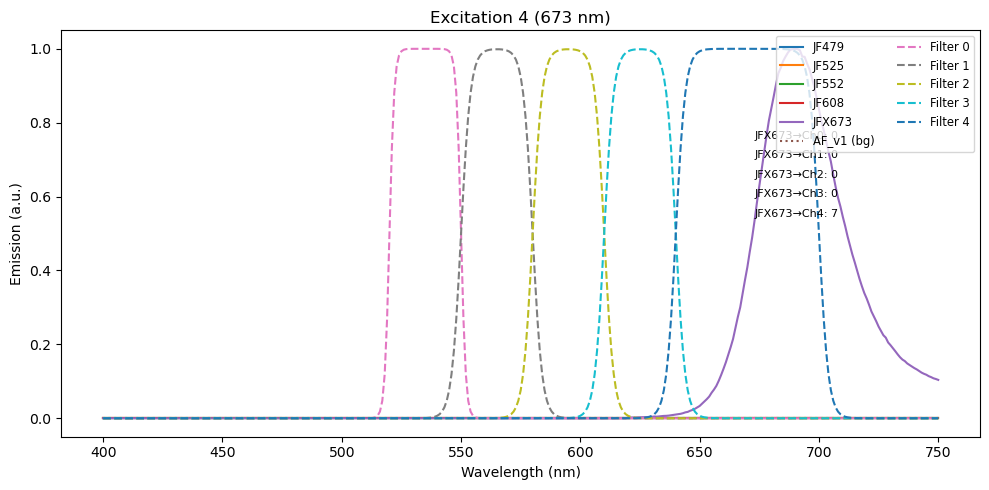

Photon counts matrix (excitation x channel):
[[1.27837001e+03 7.14576180e+02 2.96777499e+02 1.05149934e+02
  4.31926738e+01]
 [3.62046278e+02 8.09117973e+02 4.70634886e+02 1.99495698e+02
  1.03731008e+02]
 [8.99731906e+01 9.83953652e+02 8.13689203e+02 4.09108544e+02
  2.47034918e+02]
 [8.26319926e-12 3.02376401e+00 1.32199304e+02 7.32640052e+02
  7.71560741e+02]
 [5.74293084e-32 5.16972320e-10 1.68346809e-03 4.91777023e+00
  1.42880504e+03]]
Noiseless photon counts (shape: batch, n_exc, n_ch): (1, 5, 5)
[[[1.27837001e+03 7.14576180e+02 2.96777499e+02 1.05149934e+02
   4.31926738e+01]
  [3.62046278e+02 8.09117973e+02 4.70634886e+02 1.99495698e+02
   1.03731008e+02]
  [8.99731906e+01 9.83953652e+02 8.13689203e+02 4.09108544e+02
   2.47034918e+02]
  [8.26319926e-12 3.02376401e+00 1.32199304e+02 7.32640052e+02
   7.71560741e+02]
  [5.74293084e-32 5.16972320e-10 1.68346809e-03 4.91777023e+00
   1.42880504e+03]]]


In [27]:
# Run simulation without noise
counts_noiseless = []
for conc in concentrations:
    counts = sim.simulate(concentrations=conc, add_noise=False, debug=True)
    counts_noiseless.append(counts)
counts_noiseless = np.array(counts_noiseless)
print("Noiseless photon counts (shape: batch, n_exc, n_ch):", counts_noiseless.shape)
print(counts_noiseless)

In [28]:
# Run simulation with noise
counts_noisy = []
for conc in concentrations:
    
    counts = sim.simulate(concentrations=conc, add_noise=True, debug=False)
    counts_noisy.append(counts)
counts_noisy = np.array(counts_noisy)
print("Noisy photon counts (shape: batch, n_exc, n_ch):", counts_noisy.shape)
print(counts_noisy)

Noisy photon counts (shape: batch, n_exc, n_ch): (1, 5, 5)
[[[1282  714  298  101   46]
  [ 338  815  469  161  126]
  [  91  959  792  409  236]
  [   0    5  127  765  722]
  [   0    0    0    9 1426]]]


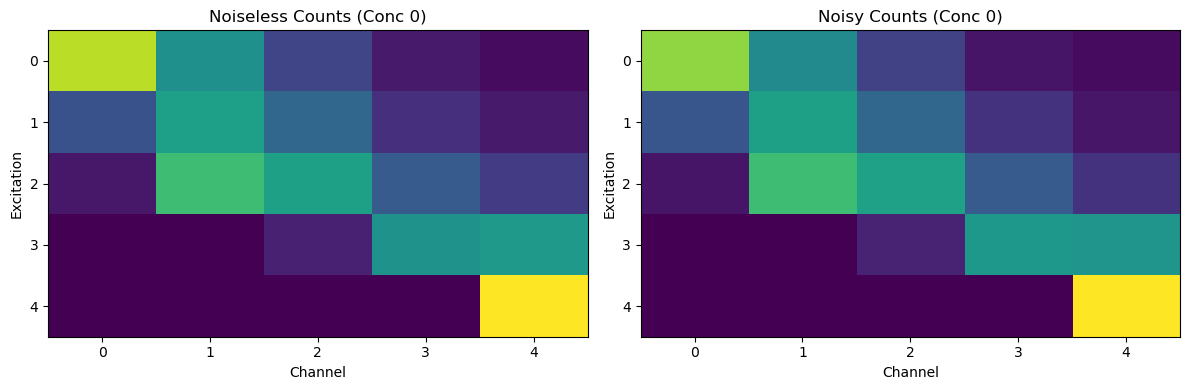

In [25]:
# Visualize simulation output
for i, conc in enumerate(concentrations):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(counts_noiseless[i], aspect='auto', interpolation='none')
    axs[0].set_title(f'Noiseless Counts (Conc {i})')
    axs[0].set_ylabel('Excitation')
    axs[0].set_xlabel('Channel')
    axs[1].imshow(counts_noisy[i], aspect='auto', interpolation='none')
    axs[1].set_title(f'Noisy Counts (Conc {i})')
    axs[1].set_ylabel('Excitation')
    axs[1].set_xlabel('Channel')
    plt.tight_layout()
    plt.show()